# Linear SVM (Julia Implementation)

We are trying to solve a problem of binary classification. Lets assume we are given a set $S$ of $n \in \mathbb{N}$ datapoints $x_k \in \mathbb{R}^m$ with corresponding labels $y_k \in \{-1, 1\}$ (for our implementations it does not really matter whether the labels are given in that form as long as there are just binary labels with 1 beeing the positive case, but assuming this makes the derivation easier). Our goal is to build and train a **Support Vector Machine** (SVM) which can be used to predict labels of new datapoints. In contrast to most other methods we will try to achive this by using linear optimzation (Simplex Algorithm).  

For notation purposes we denote the set of all $x_k \in S$ with $y_k = 1$ as $S^+$ and the set of all $x_k = -1$ as $S^-$.

In [2]:
# Instalation and Setup
# import Pkg
# Pkg.add("JuMP")
# Pkg.add("GLPK")
using JuMP, GLPK
using Printf

### Finding one seperating hyperplane
The following algorithm aims to find any seperating hyperplane of the form $a^T x = \beta, a \in \mathbb{R}^m, \beta \in \mathbb{R}$ (with $a^T x_k \geq \beta$ if $x_k \in S^+$ and $a^T x_k \leq \beta$ if $x_k \in S^-$) to split the data into two half-spaces.  
**Why does it work?**: The Simplex Algorithm is only able to solve linear optimization problems with constraints that form a polyhedron. We can view the set of all hyperplanes which seperate our data as $H = \{(a, \beta) \in \mathbb{R}^{m+1} | a^T x - \beta \leq 0, \forall x \in S^+ \text{ and } a^T x - \beta \geq 0, \forall x \in S^- \}$ (we add a Restriction for every point in our provided dataset) which is clearly a polyhedron. Now optimizing over the linear objective function $0^T a + 0 \cdot \beta$ will provide one seperating hyperplane.

In [106]:
# Input: data dict of the form ["label": 1/0 or 1/-1 or..., "x": vector]
# Output: (a, beta) which seperate our data
function findHyperplane(data)
    model = Model(GLPK.Optimizer)

    set_optimizer_attribute(model, "msg_lev", GLPK.GLP_MSG_ALL)
    @variable(model, a[1:length(data[1]["x"])])
    @variable(model, beta)
    for i in data
        # CHANGE: Change this if labels do not equal 1 fo good
        if i["label"] == 1
            @constraint(model, a' * i["x"] <= beta) 
         else
            @constraint(model, a' * i["x"] >= beta)
         end
    end
    @objective(model, Max, 0)
    JuMP.optimize!(model)
    return (JuMP.value.(a), JuMP.value.(beta))
end



findHyperplane (generic function with 1 method)

### Findind a seperating hyperplane with maximal distance SVM
The following algorithm aims to find the seperating hyperplane with maximal distance (messured in the 1-Norm so we are able to linearize the problem) to points in the sets $S^+$ and $S^-$.  
**Why does it work?**: Our goal now is to maximize the distance between any point in $S^+$ or $S^-$ and our seperating hyperplane. We can solve this problem by creating two seperating hyperplanes given by the same vector $a$ but different levels $\beta_-$ and $\beta_+$. The level of the hyperplane that maximizes the distance (in the 1 norm) between points in the sets $S^+$ and $S^-$ is than given by $\frac{1}{2} \beta_- - \beta_+$. Adding the constraints $a^T x \leq \beta_+$, $a^T x \geq \beta_-$ and maximizing the distance between both hyperplanes $\beta_- - \beta_+$ achives this. It follows from the Hölder-Inequality that requiring $\|a\|_{\infty} = 1$ (or as a linear constraint $-1 \leq a_i \leq 1$) ensures actually maximizing the L1 distance between points in $S^+$ / $S^-$ and the seperating hyperplane. 

In [81]:
# Input: data dict of the form ["label": 1/0 or 1/-1 or..., "x": vector]
# Output: (a, beta) which seperate our data optimally
function findOptimalHyperplane(data)
    model = Model(GLPK.Optimizer)

    set_optimizer_attribute(model, "msg_lev", GLPK.GLP_MSG_ALL)
    println(length(data[1]["x"]))
    @variable(model, a[1:length(data[1]["x"])])
    @variable(model, beta[1:2])
    for i in data
        if i["label"] == 1
            @constraint(model, a' * i["x"] <= beta[1]) 
         else
            @constraint(model, a' * i["x"] >= beta[2])
         end
    end
    @constraint(model, -1 .<= a .<= 1)
    @objective(model, Max, 1/2 * (beta[2] - beta[1]))
    JuMP.optimize!(model)
    return (JuMP.value.(a), JuMP.value.(beta))
end

findOptimalHyperplane (generic function with 1 method)

### Testing the SVM on example data
The following code provides an example on how to use the **findOptimalHyperplane** function. The datapoints are randomly generated by using two different multivariate normal distributions.

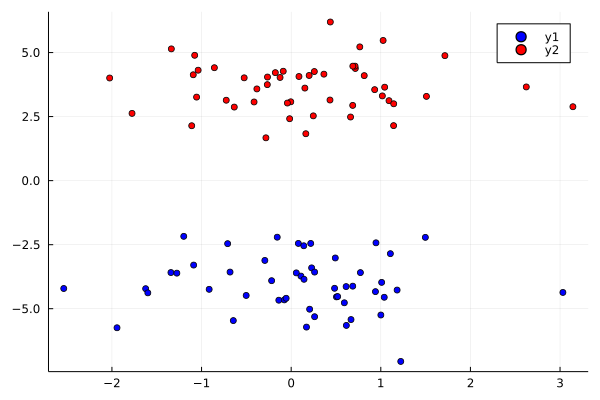

In [83]:
# Creating example data to test the given implementations
using Random, Distributions, Plots
Random.seed!(123)

d1 = Normal()
d1 = MvNormal([0, -4], [1, 1])
d2 = MvNormal([0, 4], [1, 1])

fig = plot()
x1 = rand(d1, 50)
scatter!(x1[1,:], x1[2,:], seriestype = :scatter, mc=:blue)
x2 = rand(d2, 50)
scatter!(x2[1,:], x2[2,:], seriestype = :scatter, mc=:red)
fig



In [84]:
# Create input data 
x = Vector()
for col in eachcol(x1)
    input = Dict("x" => col, "label" => 1)
    append!(x, [input])
end

for col in eachcol(x2)
    input = Dict("x" => col, "label" => -1)
    append!(x, [input])
end


a, beta = findOptimalHyperplane(x)

2
GLPK Simplex Optimizer 5.0
102 rows, 6 columns, 304 non-zeros
      0: obj =  -0.000000000e+00 inf =   2.000e+00 (2)
      3: obj =  -0.000000000e+00 inf =   0.000e+00 (0)
*     9: obj =   1.929575709e+00 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND


([0.014830848587836181, 1.0000000000000002], [-2.1922031776366517, 1.6669482410058263])

The following code plots the hyperplane coresponding to the solution that the **findOptimalHyperplane** function found.

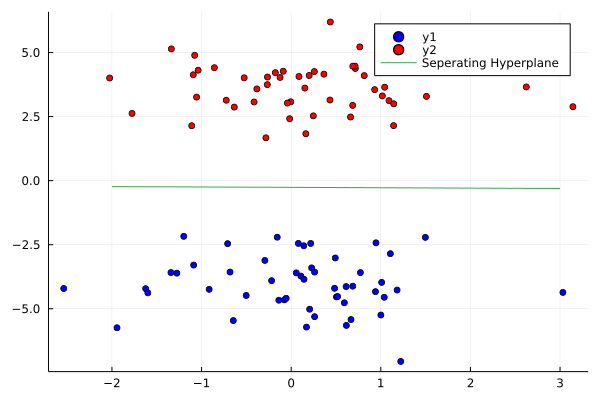

In [105]:
# Plot the resulting seperating hyperplane
lineX = -2:0.1:3
lineY = (-a[1] * lineX .+ (beta[1] + beta[2]) / 2)/a[2]

fig = plot()
scatter!(x1[1,:], x1[2,:], seriestype = :scatter, mc=:blue)
scatter!(x2[1,:], x2[2,:], seriestype = :scatter, mc=:red)
plot!(lineX, lineY, label="Seperating Hyperplane")
fig